# Convolution Neural Networks

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

## Simple CNN Structure in MNIST

In [14]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyper-parameters
input_size = 1     #Gray-scale images
classes    = 10
lr         = 0.001
batch_size = 128
epochs     = 5

Using device: cuda


**Data Preprocessing**

In [15]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.1307, ), (0.3081, )) #Mean and Std of MNIST 
])

train_dataset = datasets.MNIST(root = "./data", train = True, download = True, transform = transform)
test_dataset  = datasets.MNIST(root = "./data", train = False, download = True, transform = transform)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader  = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

**CNN Structure**

In [18]:
class SimpleCNN(nn.Module):
	def __init__(self, inplanes = 1, num_classes = 10):
		super(SimpleCNN, self).__init__()
		# Input 1 x 28 x 28
		# CONV1:
		self.conv1 = nn.Conv2d(in_channels = inplanes, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
		self.relu1 = nn.ReLU()
			#Output: 32 x 14 x 14
		# CONV2:
		self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
		self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
		self.relu2 = nn.ReLU()
			#Output: 64 x 7 x 7
		#Flatten & Dense
		self.fc1 = nn.Linear(64 * 7 * 7, 128)
		self.relu3 = nn.ReLU()
		self.fc2 = nn.Linear(128, num_classes)
		
	def forward(self, x):
		#Conv1
		x = self.conv1(x)
		x = self.relu1(x)
		x = self.pool1(x)
		#Conv2
		x = self.conv2(x)
		x = self.relu2(x)
		x = self.pool2(x)
		#Flatten
		x = x.view(x.size(0), -1)
		#Dense
		x = self.fc1(x)
		x = self.relu3(x)
		x = self.fc2(x)
		
		return x

**Training**

In [19]:
# Init
model = SimpleCNN(inplanes = input_size, num_classes = classes).to(device)
print(model)

# Loss function and Optimizer
criterion = nn.CrossEntropyLoss() # Softmax Included
optimizer = optim.Adam(model.parameters(), lr = lr)

# Training
for epoch in range(epochs):
    #Training mode
    model.train()
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data    = data.to(device)
        targets = targets.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
		
        # Backward pass and Criterion
        optimizer.zero_grad()
        loss.backward()       #Gradient
        optimizer.step()      #Update weights
		
        if (batch_idx + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
		
    print(f'--- Epoch {epoch+1} Finished, Average Loss: {running_loss/len(train_loader):.4f} ---')

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Epoch [1/5], Step [100/469], Loss: 0.0943
Epoch [1/5], Step [200/469], Loss: 0.1430
Epoch [1/5], Step [300/469], Loss: 0.0656
Epoch [1/5], Step [400/469], Loss: 0.1048
--- Epoch 1 Finished, Average Loss: 0.1789 ---
Epoch [2/5], Step [100/469], Loss: 0.0880
Epoch [2/5], Step [200/469], Loss: 0.0423
Epoch [2/5], Step [300/469], Loss: 0.0180
Epoch [2/5], Step [400/469], Loss: 0.0138
--- Epoch 2 Finished, Average Loss: 0.0504 ---
Epoch [3/5], Step [100/469], Loss: 0.0142
Epoch [3/5],

**Evaluation**

In [20]:
# Evaluation mode
model.eval()
test_loss = 0
correct   = 0
total     = 0

with torch.no_grad():
    for data, targets in test_loader:
        data    = data.to(device)
        targets = targets.to(device)
        outputs = model(data)
		
        loss = criterion(outputs, targets)
        test_loss += loss.item()
		
        _, predicted = torch.max(outputs.data, 1)
        total   += targets.size(0)
        correct += (predicted == targets).sum().item()

test_loss /= len(test_loader)
accuracy   = correct / total * 100.0
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {accuracy:.2f}%')

Test Loss: 0.0505
Test Accuracy: 98.49%


**Test**

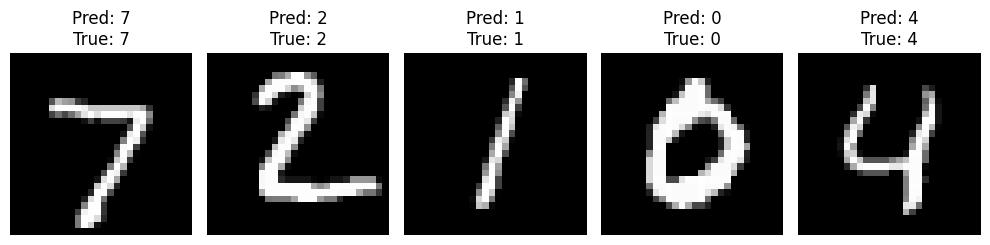

In [21]:
model.eval()
with torch.no_grad():
    data, targets = next(iter(test_loader))
    data = data.to(device)
    outputs = model(data)
    _, predicted_labels = torch.max(outputs.data, 1)
	
    # CPU
    data_cpu = data.cpu()
    targets_cpu = targets.cpu()
    predicted_labels_cpu = predicted_labels.cpu()
	
    # Visualization function
    def imshow(img):
        img   = img * 0.3081 + 0.1307 # Un-normalize: img * std + mean
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray') # Bỏ chiều kênh nếu là ảnh xám
        plt.axis('off')
		
    # Visulize
    num_images_to_show = 5
    plt.figure(figsize=(10, 3))
    for i in range(num_images_to_show):
        plt.subplot(1, num_images_to_show, i+1)
        imshow(data_cpu[i])
        plt.title(f"Pred: {predicted_labels_cpu[i].item()}\nTrue: {targets_cpu[i].item()}")
    plt.tight_layout()
    plt.show()

## Visualize Feature Maps
For fun :v

In [26]:
import math

**Hook**

In [28]:
# Prepare Hook and Save
activation_maps = {}
def get_activation(name):
    def hook(model, input, output):
        activation_maps[name] = output.detach().cpu()
    return hook

# Hook Registration
hooks = []
hooks.append(model.conv1.register_forward_hook(get_activation('conv1')))
hooks.append(model.relu1.register_forward_hook(get_activation('relu1')))
hooks.append(model.pool1.register_forward_hook(get_activation('pool1')))
hooks.append(model.conv2.register_forward_hook(get_activation('conv2')))
hooks.append(model.relu2.register_forward_hook(get_activation('relu2')))
hooks.append(model.pool2.register_forward_hook(get_activation('pool2')))

**Run**

In [29]:
# Get 1 sample image
vis_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)
iterator = iter(vis_loader)
try:
    sample_data, sample_target_tensor = next(iterator)
except StopIteration:
    print("Error")
    exit()

sample_data = sample_data.to(device)

# Get label scalar value (tensor shape [1] -> scalar)
if sample_target_tensor.numel() == 1:
    sample_target_value = sample_target_tensor.item()
    print(f"True Label: {sample_target_value}")
else:
    sample_target_value = sample_target_tensor[0].item()

True Label: 5


In [30]:
# Run Model
model.eval()
with torch.no_grad():
    output = model(sample_data)
    _, predicted_label_tensor = torch.max(output.data, 1)

    if predicted_label_tensor.numel() == 1:
        predicted_label_value = predicted_label_tensor.item()
    else:
        predicted_label_value = predicted_label_tensor[0].item()
    
    print(f"Predicted: {predicted_label_value}")

Predicted: 5


In [31]:
# Remove hooks
for h in hooks:
    h.remove()

**Visualization Feature Maps**

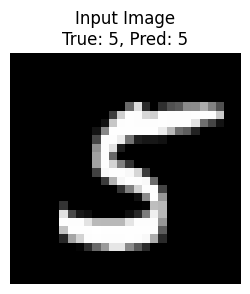

--- Feature maps ---
Visualizing output for layer: conv1


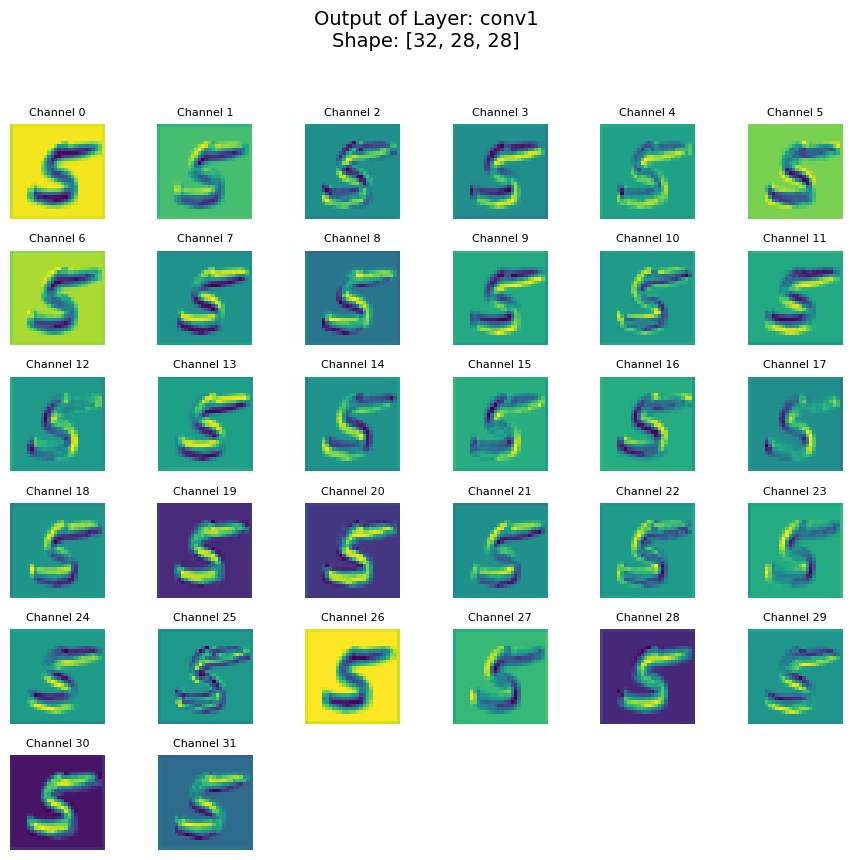

Visualizing output for layer: relu1


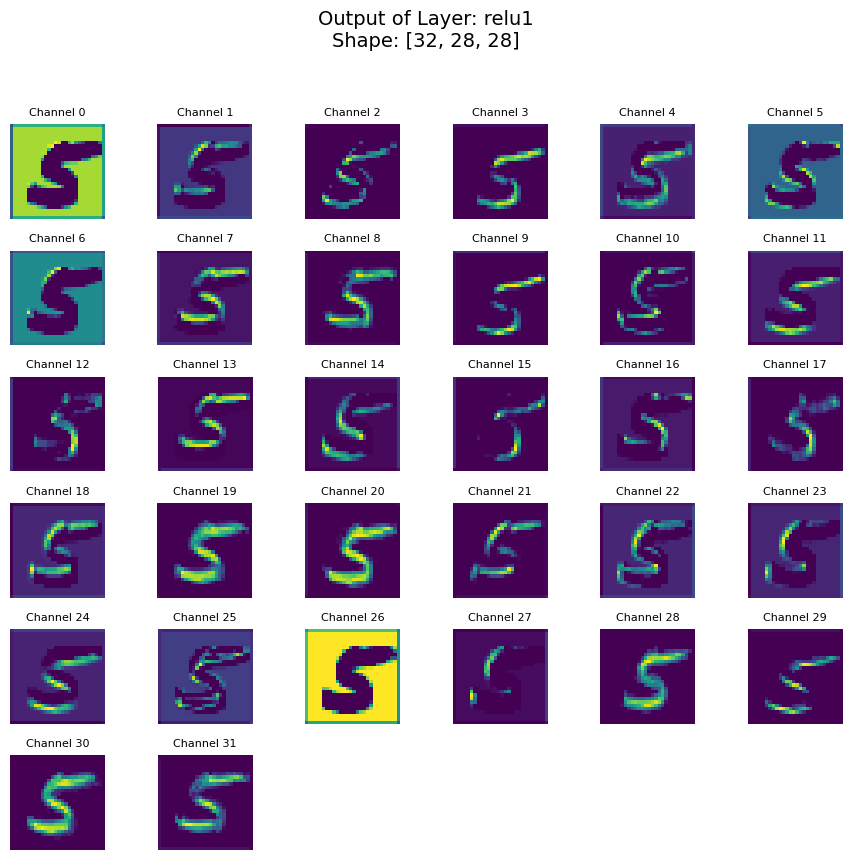

Visualizing output for layer: pool1


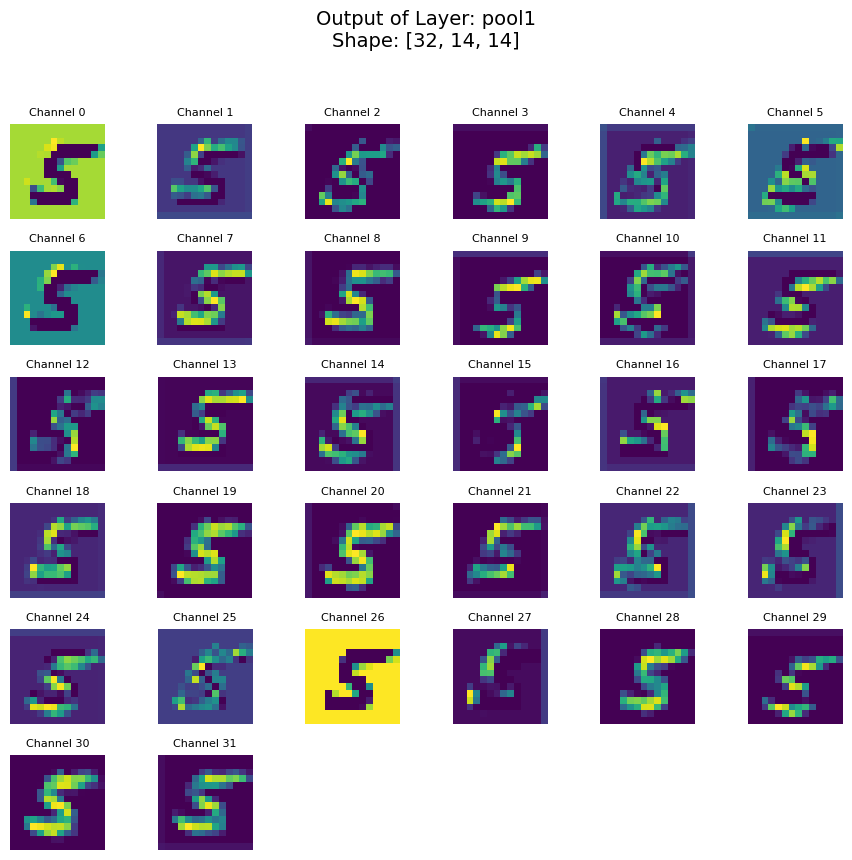

Visualizing output for layer: conv2


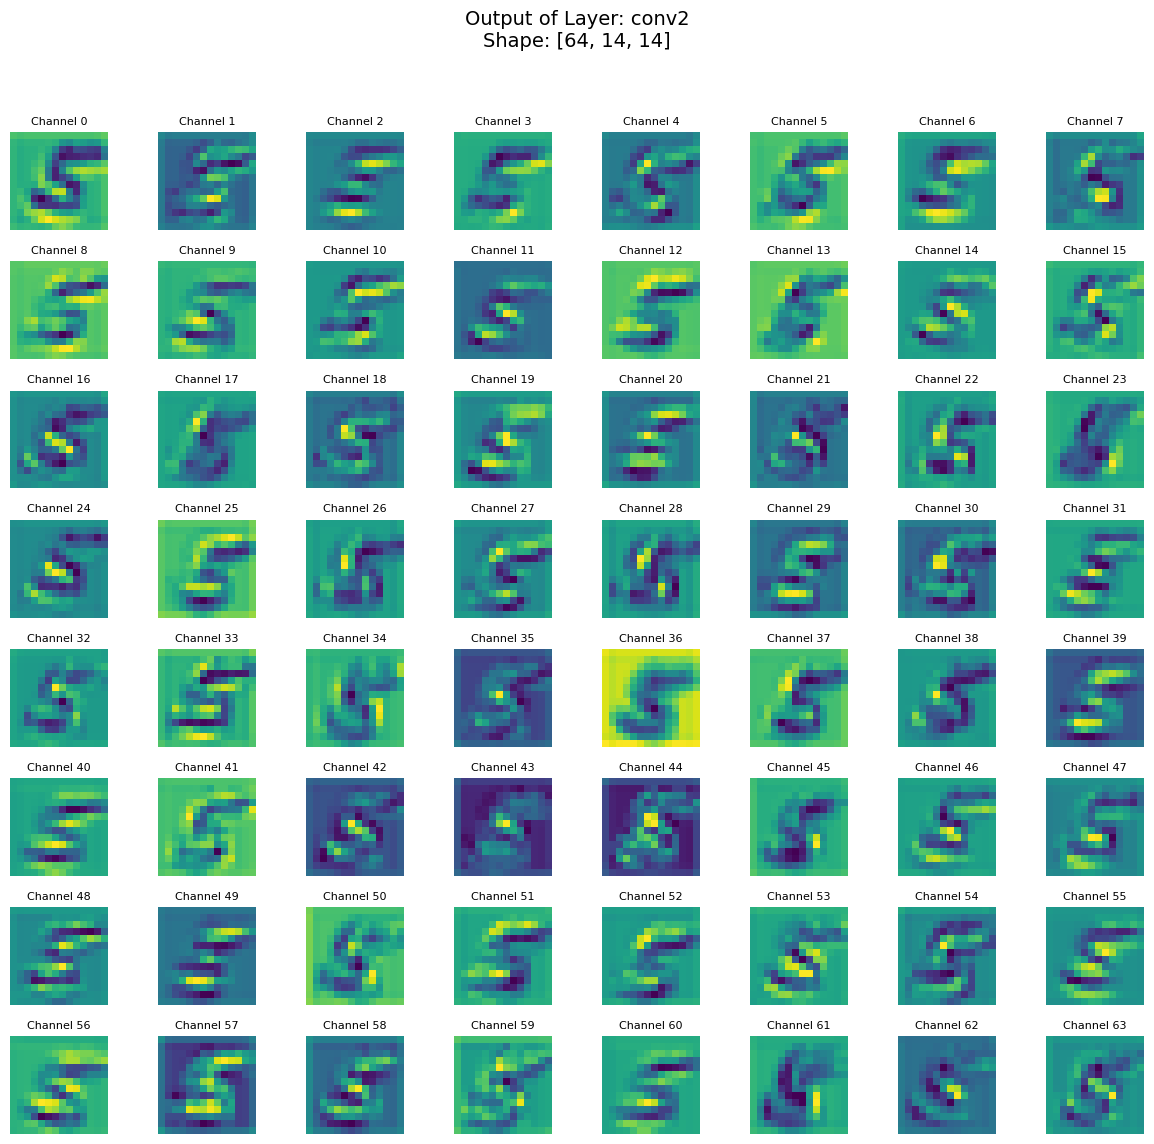

Visualizing output for layer: relu2


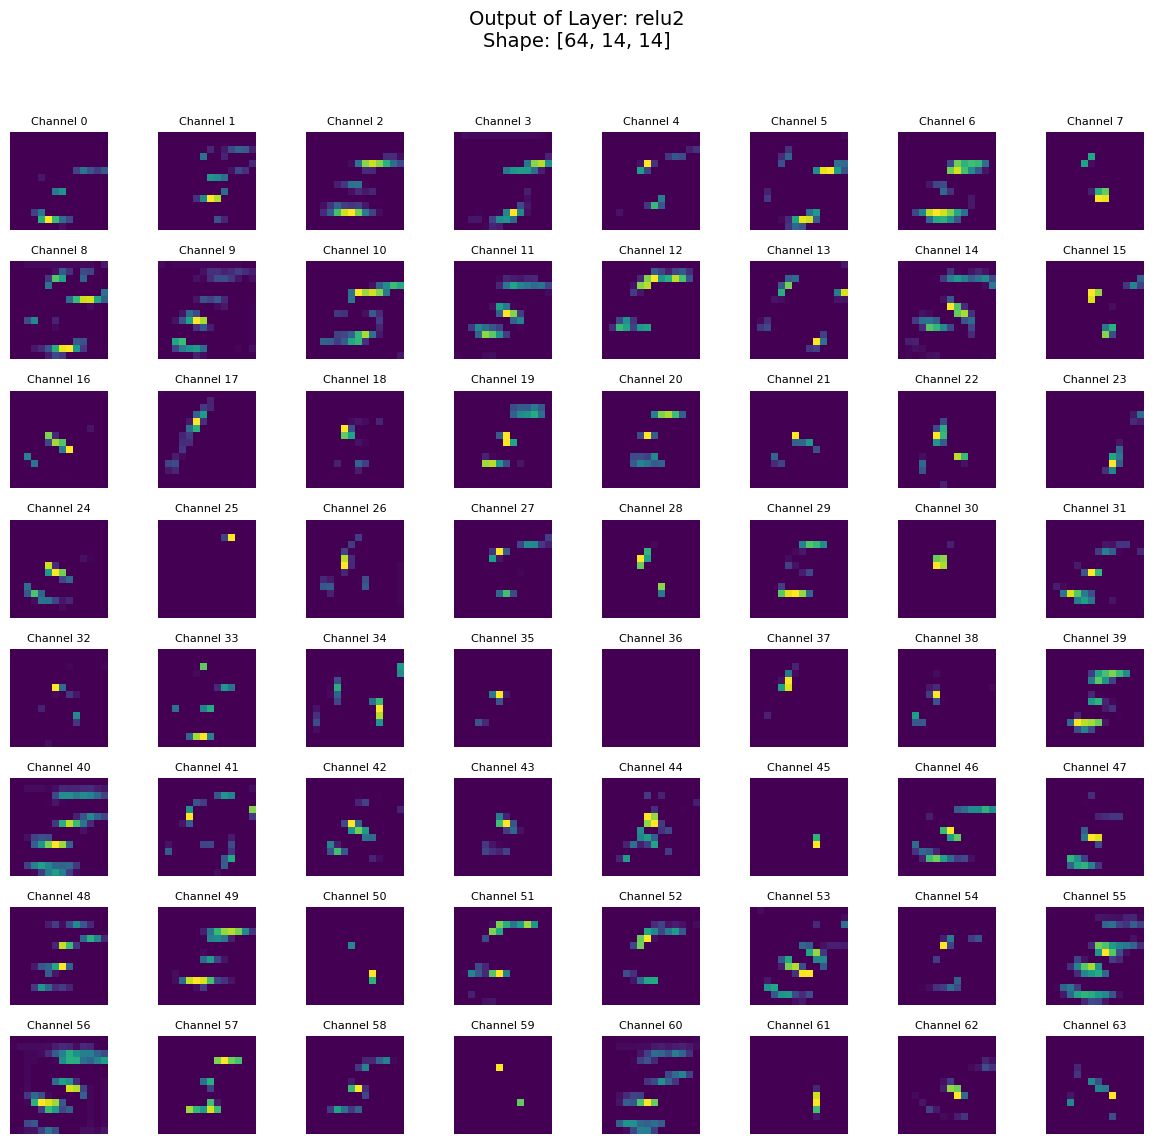

Visualizing output for layer: pool2


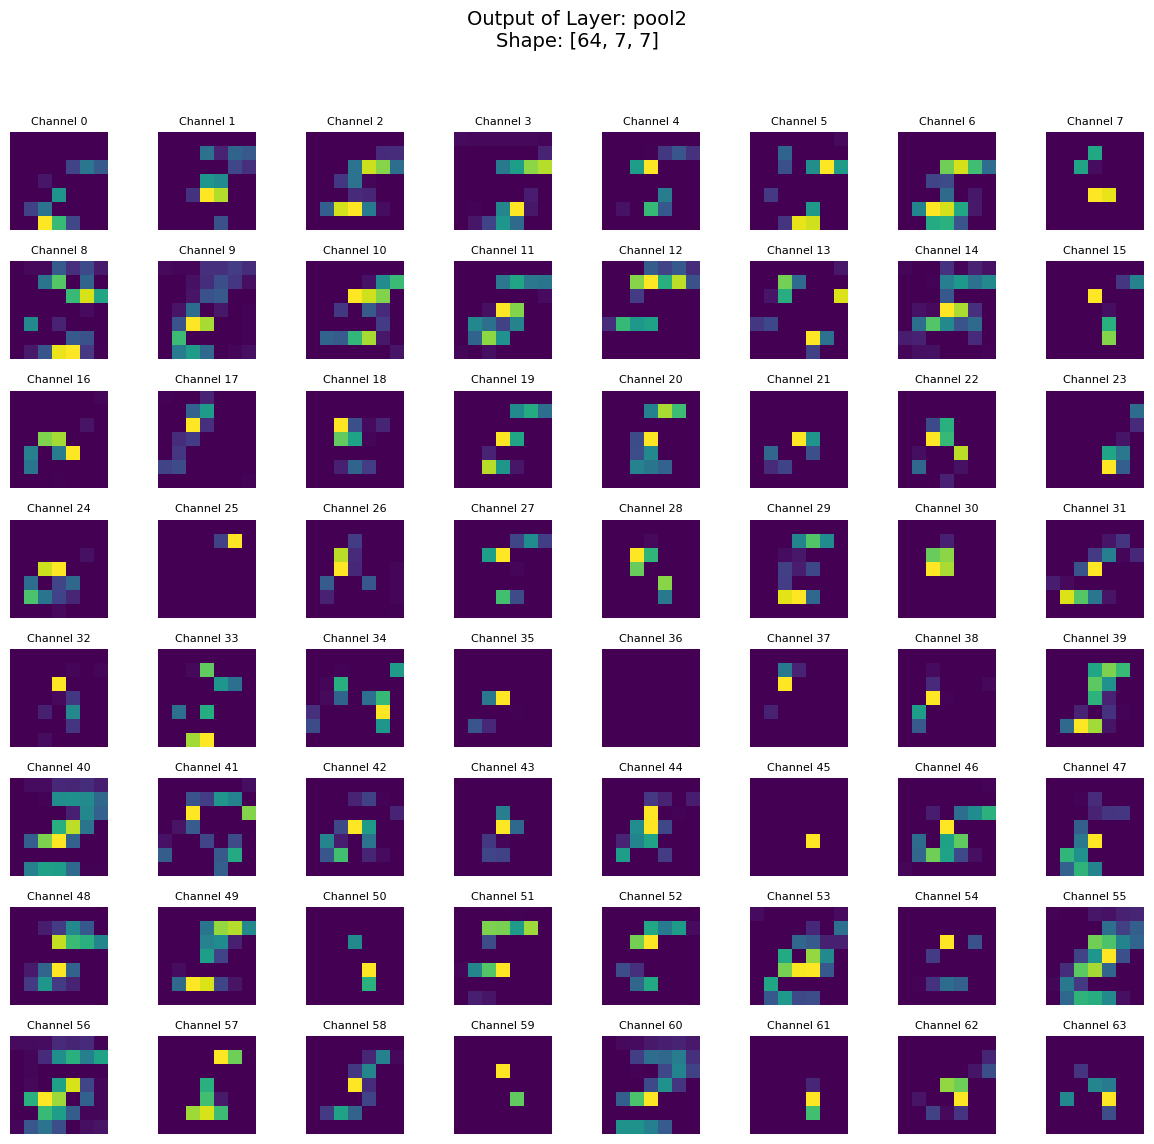

In [32]:
# Visualize feature maps
def visualize_feature_maps(feature_maps_tensor, title="Feature Maps"):
    """Grid visualize"""
    if feature_maps_tensor.dim() == 4 and feature_maps_tensor.size(0) == 1:
        feature_maps = feature_maps_tensor.squeeze(0)
    else:
        if feature_maps_tensor.dim() == 4 and feature_maps_tensor.size(0) > 1:
             feature_maps = feature_maps_tensor[0]
        else:
             return

    num_channels = feature_maps.size(0)
    grid_size = math.ceil(math.sqrt(num_channels))

    plt.figure(figsize = (min(grid_size * 1.5, 20), min(grid_size * 1.5, 20)))
    plt.suptitle(f"{title}\nShape: {list(feature_maps.shape)}", fontsize = 14)

    for i in range(num_channels):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        map_np = feature_maps[i].numpy()
        # Normalize: map -> [0, 1]
        map_np_normalized = (map_np - map_np.min()) / (map_np.max() - map_np.min() + 1e-6) # Avoid divide by 0
        plt.imshow(map_np_normalized, cmap='viridis')
        plt.title(f"Channel {i}", fontsize=8)
        plt.xticks([])
        plt.yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Visualize Image and Saved feature maps
# Un-normalize Image
sample_data_unnormalized = sample_data.cpu().squeeze(0) * 0.3081 + 0.1307
plt.figure(figsize = (3, 3))
plt.imshow(sample_data_unnormalized.permute(1, 2, 0).numpy().squeeze(), cmap='gray')

plt.title(f"Input Image\nTrue: {sample_target_value}, Pred: {predicted_label_value}")
plt.axis('off')
plt.show()

# Visualize output of each hooked layer
print("--- Feature maps ---")
if not activation_maps:
    print("No saved feature map")
else:
    for name, maps in activation_maps.items():
        print(f"Visualizing output for layer: {name}")
        visualize_feature_maps(maps, title=f"Output of Layer: {name}")

****